In [1]:
import numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
from numba import jit, prange
from datetime import datetime

In [2]:
def getsystem(N):
    h = 1./(N+1.)
    C = 4*np.eye(N) + np.diag(-np.ones(N-1),k=1) + 1*np.diag(-np.ones(N-1),k=-1)
    A = np.diag(-np.ones(N*N-N),k=-N) + np.diag(-np.ones(N*N-N),k=N) + block_diag(*([C]*N))
    b = np.full(N*N,h**2.0)
    return A

In [3]:
getsystem(2)

array([[ 4., -1., -1.,  0.],
       [-1.,  4.,  0., -1.],
       [-1.,  0.,  4., -1.],
       [ 0., -1., -1.,  4.]])

In [4]:
def compute(a, b, x, y):
    A = ((1+a)*b*(x+y) -a)
    B = ((1+a)*b*(x-y) -a)
    return A,B

In [5]:
def system(N):
    A =1
    B=1
    a=1
    h = 1./(N+1.)
    C = (4+h**2*a)*np.eye(N) + (-1+(h*B/2))*np.diag(np.ones(N-1),k=1) + (-1*(h*A/2))*np.diag(-np.ones(N-1),k=-1)
    #M = np.diag(-np.ones(N*N-N),k=-N) + np.diag(-np.ones(N*N-N),k=N) + block_diag(*([C]*N))
    M = np.diag(-np.ones(N*N-N), k=-N) + np.diag(-np.ones(N*N-N), k=N) + block_diag(*([C]*N))
    b = np.full(N*N,2)
    x0 = np.full(N*N,0.0)
    return M,b,x0

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time
#@jit(parallel=True)
def jacobi(A, b, x0, max_iter=100, tol=1e-6):
    """
    Jacobi method for solving Ax=b.
    A: coefficient matrix
    b: constant vector
    x0: initial guess
    max_iter: maximum number of iterations (default 100)
    tol: tolerance for convergence (default 1e-6)
    """
    n = len(A)
    x = x0.copy()
    res = []
    #start_time = datetime.now()
    for k in range(max_iter):
        x_new = np.zeros(n)
        for i in range(n):
            s = 0.0
            for j in prange(n):
                if j != i:
                    s += A[i,j] * x[j]
            x_new[i] = (b[i] - s) / A[i,i]
        r = np.linalg.norm(A @ x - b)
        res.append(r)
        if r < tol:
            break
        x = x_new
    plt.semilogy(res)
    plt.xlabel('Iteration')
    plt.ylabel('Residual')
    plt.show()
    #end_time = datetime.now()
    #elapsed_time = end_time - start_time
    #print(f"The for loop took {elapsed_time.total_seconds()} seconds to execute.")
    return x, res

#start_time = time.time()

# your for loop here

#end_time = time.time()
#elapsed_time = end_time - start_time

#print(f"The for loop took {elapsed_time} seconds to execute.")

In [27]:
A,b,x0 =system(20)

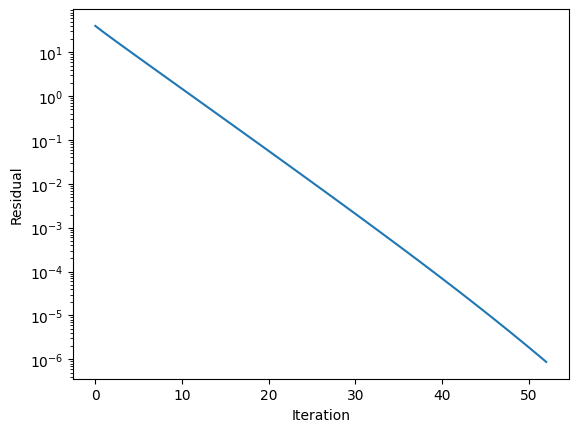

The for loop took 5.902334928512573 seconds to execute.


In [9]:

start_time = time.time()

x, res = jacobi(A, b, x0)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"The for loop took {elapsed_time} seconds to execute.")

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time
@jit(parallel=True)
def jacobi(A, b, x0, max_iter=100, tol=1e-6):
    """
    Jacobi method for solving Ax=b.
    A: coefficient matrix
    b: constant vector
    x0: initial guess
    max_iter: maximum number of iterations (default 100)
    tol: tolerance for convergence (default 1e-6)
    """
    n = len(A)
    x = x0.copy()
    res = []
    #start_time = datetime.now()
    for k in range(max_iter):
        x_new = np.zeros(n)
        for i in range(n):
            s = 0.0
            for j in prange(n):
                if j != i:
                    s += A[i,j] * x[j]
            x_new[i] = (b[i] - s) / A[i,i]
        r = np.linalg.norm(A @ x - b)
        res.append(r)
        if r < tol:
            break
        x = x_new
    plt.semilogy(res)
    plt.xlabel('Iteration')
    plt.ylabel('Residual')
    plt.show()
    #end_time = datetime.now()
    #elapsed_time = end_time - start_time
    #print(f"The for loop took {elapsed_time.total_seconds()} seconds to execute.")
    return x, res

In [11]:
import numba as nb
import numpy as np
import matplotlib.pyplot as plt

@nb.njit(parallel=True)
def jacobi_numba(A, b, x0, max_iter=100, tol=1e-6):
    """
    Jacobi method for solving Ax=b.
    A: coefficient matrix
    b: constant vector
    x0: initial guess
    max_iter: maximum number of iterations (default 100)
    tol: tolerance for convergence (default 1e-6)
    """
    n = len(A)
    x = x0.copy()
    res = []
    for k in range(max_iter):
        x_new = np.zeros(n)
        for i in nb.prange(n):
            s = 0
            for j in range(n):
                if j != i:
                    s += A[i,j] * x[j]
            x_new[i] = (b[i] - s) / A[i,i]
        r = np.linalg.norm(A @ x - b)
        res.append(r)
        if r < tol:
            break
        x = x_new
    return x, res


The for loop took 2.3688764572143555 seconds to execute.


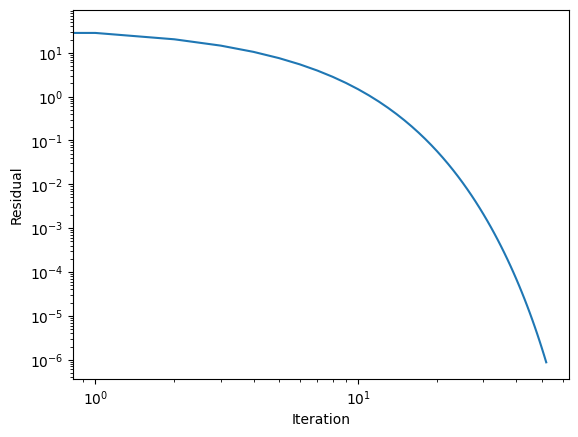

In [12]:
start_time = time.time()

x,res = jacobi_numba(A, b, x0)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The for loop took {elapsed_time} seconds to execute.")
plt.loglog(res)
plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.show()

In [13]:
import numba as nb
import numpy as np

@nb.njit(parallel=True, fastmath=True, nopython=True)
def jacob(A, b, x0, tol=1e-8, max_iters=1000):
    n = len(A)
    x = np.copy(x0)
    iters = 0
    while iters < max_iters:
        x_old = np.copy(x)
        for i in nb.prange(n):
            s = 0.0
            for j in range(n):
                if i != j:
                    s += A[i,j] * x_old[j]
            x[i] = (b[i] - s) / A[i,i]
        if np.linalg.norm(x - x_old) < tol:
            break
        iters += 1
    return x, iters


/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [14]:
from numba import njit, prange
import numpy as np

@njit(parallel=True)
def prange_wrong_result(x):
    n = x.shape[0]
    y = np.zeros(4)
    for i in prange(n):
        # accumulating into the same element of `y` from different
        # parallel iterations of the loop results in a race condition
        y[i % 4] += x[i]

    return y

In [15]:
x= np.linspace(1,5)
prange_wrong_result(x)

array([35.18367347, 33.24489796, 30.24489796, 36.48979592])

In [17]:
A,b,x0 =system(20)

In [18]:
start_time = time.time()

x, res =jacob(A, b, x0)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"The for loop took {elapsed_time} seconds to execute.")

The for loop took 1.0944483280181885 seconds to execute.


In [19]:
def system(N):
    A = 1
    B = 1
    a = 1
    h = 1. / (N + 1.)
    C = (4 + h ** 2 * a) * np.eye(N) + (-1 + (h * B / 2)) * np.diag(np.ones(N - 1), k=1) + (-1 * (h * A / 2)) * np.diag(-np.ones(N - 1), k=-1)
    M = np.diag(-np.ones(N * N - N), k=-N) + np.diag(-np.ones(N * N - N), k=N) + block_diag(*([C] * N))
    b = np.full(N * N, 2)
    x0 = np.full(N * N, 0.0)
    return M, b, x0

In [20]:
M, b, x0 = system(10)

In [21]:
import numpy as np
from numba import jit
from scipy.linalg import block_diag
import matplotlib.pyplot as plt


@jit(nopython=True)
def jacob(A, b, x0, max_iter=100, tol=1e-6):
    """
    Jacobi method for solving Ax=b.
    A: coefficient matrix
    b: constant vector
    x0: initial guess
    max_iter: maximum number of iterations (default 100)
    tol: tolerance for convergence (default 1e-6)
    """
    n = len(A)
    x = x0.copy()
    res = np.zeros(max_iter)
    for k in range(max_iter):
        x_new = np.zeros(n)
        for i in range(n):
            s = 0.0
            for j in range(n):
                if j != i:
                    s += A[i,j] * x[j]
            x_new[i] = (b[i] - s) / A[i,i]
        r = np.linalg.norm(A @ x - b)
        res[k] = r
        if r < tol:
            break
        x = x_new
    return x, res[:k+1]


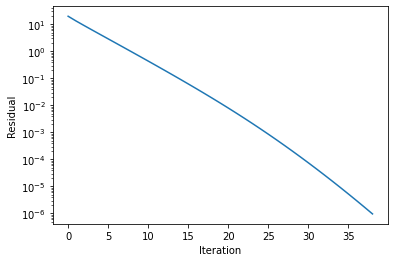

In [ ]:
x, res = jacob(M, b, x0)
plt.semilogy(res)
plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.show()

### Serial Gauss-Seidel

In [22]:
import numpy as np
import numba as nb

def gauss_seidel(A, b, x0, max_iter=100, tol=1e-6):
    n = len(A)
    x = x0.copy()
    res = np.zeros(max_iter+1)
    res[0] = np.linalg.norm(A @ x - b)
    for k in range(max_iter):
        for i in range(n):
            s = b[i]
            for j in range(n):
                if j != i:
                    s -= A[i,j] * x[j]
            x[i] = s / A[i,i]
        res[k+1] = np.linalg.norm(A @ x - b)
        if res[k+1] < tol:
            break
    return x, res[:k+1]


In [29]:
A,b,x0 =system(20)

The for loop took 0.27608728408813477 seconds to execute.


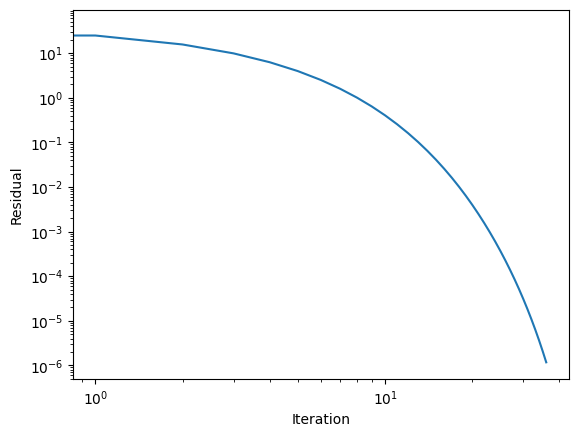

In [30]:
start_time = time.time()

x,res = gauss_seidel(A, b, x0)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The for loop took {elapsed_time} seconds to execute.")
plt.loglog(res)
plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.show()

### Parallelized Gauss-Seidel

In [31]:
import numpy as np
import numba as nb

@nb.njit(parallel=True)
def gauss_seidel(A, b, x0, max_iter=100, tol=1e-6):
    n = len(A)
    x = x0.copy()
    res = np.zeros(max_iter+1)
    res[0] = np.linalg.norm(A @ x - b)
    for k in nb.prange(max_iter):
        for i in range(n):
            s = b[i]
            for j in nb.prange(n):
                if j != i:
                    s -= A[i,j] * x[j]
            x[i] = s / A[i,i]
        res[k+1] = np.linalg.norm(A @ x - b)
        if res[k+1] < tol:
            break
    return x, res[:k+1]


The for loop took 1.6117677688598633 seconds to execute.


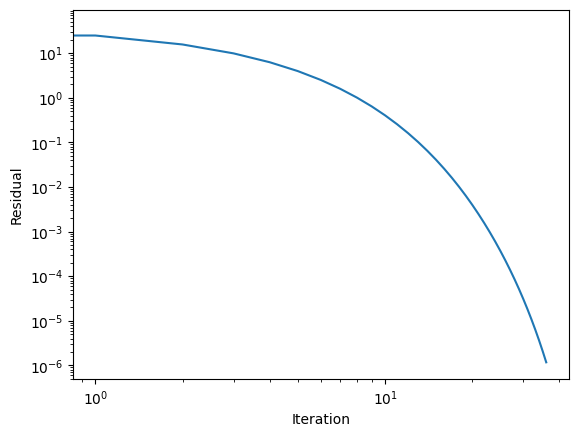

In [32]:
start_time = time.time()

x,res = gauss_seidel(A, b, x0)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The for loop took {elapsed_time} seconds to execute.")
plt.loglog(res)
plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.show()